# Import các thư viện cần thiết

In [1]:
import numpy as np
import datetime as dt 
import pandas as pd
import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import pmdarima as pm
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load dữ liệu thông qua API từ web.
import requests
symbol_id = 'BITSTAMP_SPOT_BCH_USD'
period_id = '1DAY'
time_start='2021-01-01'
time_end="2022-01-01"
limit='10000'
symbol_name='BCH'
headers = {'X-CoinAPI-Key' : '43CBEEAE-257B-4F4B-82A5-DEC72E93A63E'}
response = requests.get(
f'https://rest.coinapi.io/v1/ohlcv/{symbol_id}/history?period_id={period_id}&time_start={time_start}&time_end={time_end}&limit={limit}',
headers=headers)


In [3]:
#Chuyển đổi dữ liệu sang dạng DataFrame.
from pandas import json_normalize
dictr = response.json()
df = json_normalize(dictr)

In [4]:
df

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2021-01-01T00:00:00.0000000Z,2021-01-02T00:00:00.0000000Z,2021-01-01T00:03:12.6150000Z,2021-01-01T23:58:27.4330000Z,342.74,355.93,332.00,342.50,7899.661575,1827
1,2021-01-02T00:00:00.0000000Z,2021-01-03T00:00:00.0000000Z,2021-01-02T00:00:07.1560000Z,2021-01-02T23:59:40.0290000Z,342.86,368.84,334.39,354.45,19312.140340,3396
2,2021-01-03T00:00:00.0000000Z,2021-01-04T00:00:00.0000000Z,2021-01-03T00:00:47.2290000Z,2021-01-03T23:59:45.4690000Z,354.90,434.54,354.65,423.71,38108.922182,7657
3,2021-01-04T00:00:00.0000000Z,2021-01-05T00:00:00.0000000Z,2021-01-04T00:00:20.7520000Z,2021-01-04T23:59:20.3090000Z,425.20,467.67,377.00,406.28,46750.940584,9969
4,2021-01-05T00:00:00.0000000Z,2021-01-06T00:00:00.0000000Z,2021-01-05T00:01:23.6910000Z,2021-01-05T23:59:22.2090000Z,409.08,426.22,380.21,420.05,26111.978197,4527
...,...,...,...,...,...,...,...,...,...,...
360,2021-12-27T00:00:00.0000000Z,2021-12-28T00:00:00.0000000Z,2021-12-27T00:03:33.9000000Z,2021-12-27T23:58:47.5850000Z,452.65,475.88,448.07,465.34,5278.753228,2122
361,2021-12-28T00:00:00.0000000Z,2021-12-29T00:00:00.0000000Z,2021-12-28T00:00:03.3790000Z,2021-12-28T23:58:32.5210000Z,465.35,465.41,438.25,438.89,3727.952690,1939
362,2021-12-29T00:00:00.0000000Z,2021-12-30T00:00:00.0000000Z,2021-12-29T00:00:17.3020000Z,2021-12-29T23:58:49.2900000Z,438.96,445.51,426.62,429.78,4011.802759,1622
363,2021-12-30T00:00:00.0000000Z,2021-12-31T00:00:00.0000000Z,2021-12-30T00:03:20.9110000Z,2021-12-30T23:59:43.5430000Z,428.98,437.32,423.83,431.87,3639.521695,1546


In [5]:
#Tải bộ dữ liệu thô.
# df.to_csv('raw_data_final.csv')

In [6]:
#Xem qua thông tin về dữ liệu.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time_period_start  365 non-null    object 
 1   time_period_end    365 non-null    object 
 2   time_open          365 non-null    object 
 3   time_close         365 non-null    object 
 4   price_open         365 non-null    float64
 5   price_high         365 non-null    float64
 6   price_low          365 non-null    float64
 7   price_close        365 non-null    float64
 8   volume_traded      365 non-null    float64
 9   trades_count       365 non-null    int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 28.6+ KB


In [7]:
#Kiểm tra số lượng dữ liệu bị rỗng.
df.isnull().sum().sum()

0

In [8]:
#Điều chỉnh format ngày tháng và bỏ đi những cột không cần thiết.
df['time_period_start']=df['time_period_start'].apply(lambda x: x.split('T')[0])
df=df.drop(['time_period_end','time_open','time_close','volume_traded','trades_count'
            ,'price_high','price_low','price_open'],axis=1)
df=df.rename(columns={'time_period_start':'Date','price_close':'Close'})
df

,Date,Close
0,2021-01-01,342.50
1,2021-01-02,354.45
2,2021-01-03,423.71
3,2021-01-04,406.28
4,2021-01-05,420.05
...,...,...
360,2021-12-27,465.34
361,2021-12-28,438.89
362,2021-12-29,429.78
363,2021-12-30,431.87


In [9]:
#Set cột date làm index
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

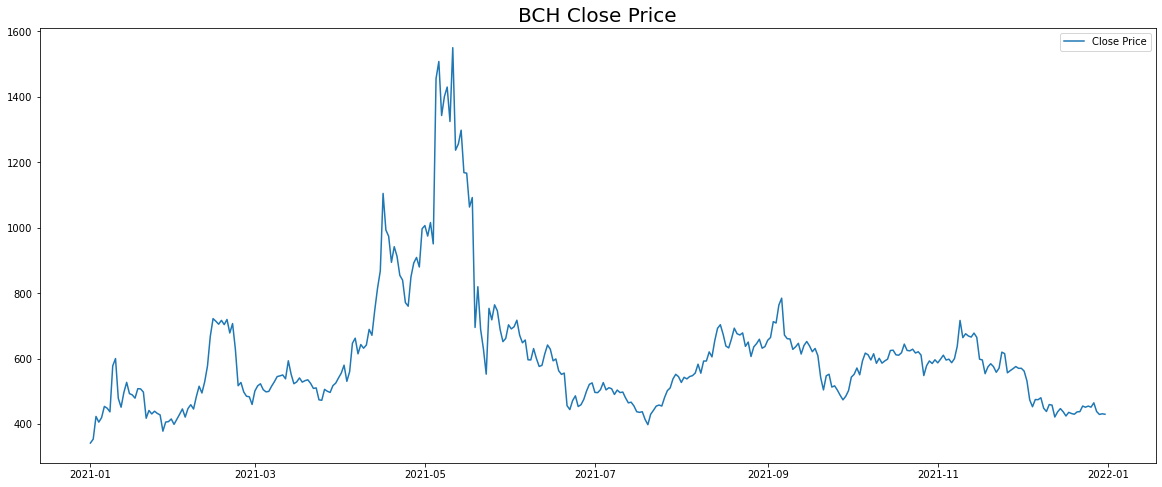

In [10]:
# Biểu đồ dữ liệu giá đóng cửa BCH
plt.figure(figsize=(20,8))
plt.title('BCH Close Price',fontsize=20)
plt.plot(df['Close'], label='Close Price')
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


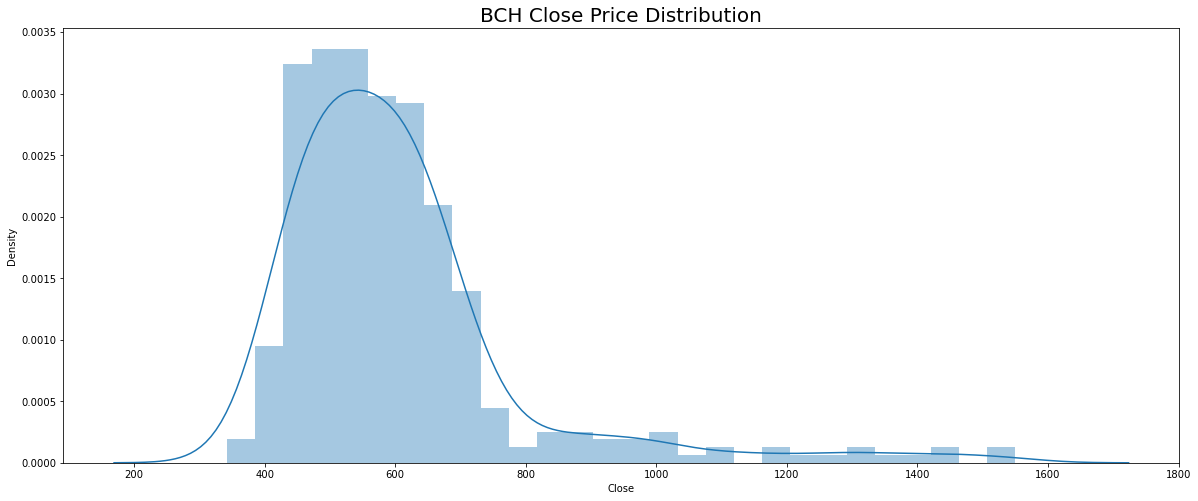

In [11]:
#Phân phối của dữ liệu
plt.figure(figsize=(20,8))
plt.title('BCH Close Price Distribution',fontsize=20)
sns.distplot(df['Close'])

KẾT QUẢ PHÂN RÃ CHUỖI DỮ LIỆU


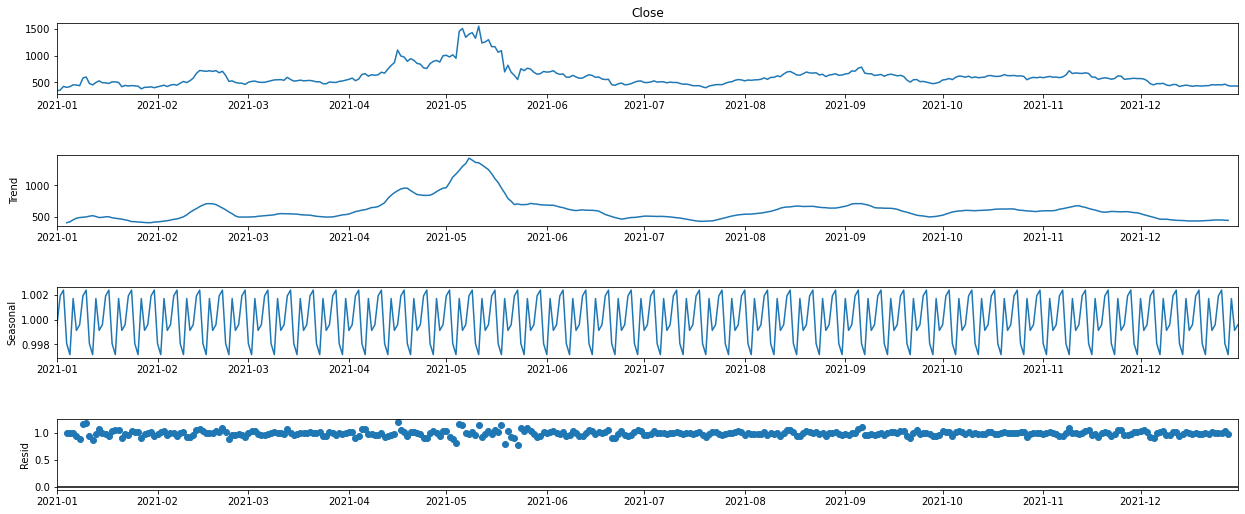

<Figure size 1440x576 with 0 Axes>

In [12]:
#Phân rã dữ liệu
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_results = seasonal_decompose(df['Close'], 
                                           model='multiplicative')
decomposition_results.plot().set_size_inches(20, 8)
plt.figure(figsize=(20,8))
print('KẾT QUẢ PHÂN RÃ CHUỖI DỮ LIỆU')
plt.show()

In [13]:
#Đặt mốc để chia bộ dữ liệu ra tập train-test
splitting_landmark=int(len(df)*0.8)

# Phương pháp mô phỏng Monte Carlo

<function matplotlib.pyplot.show(*args, **kw)>

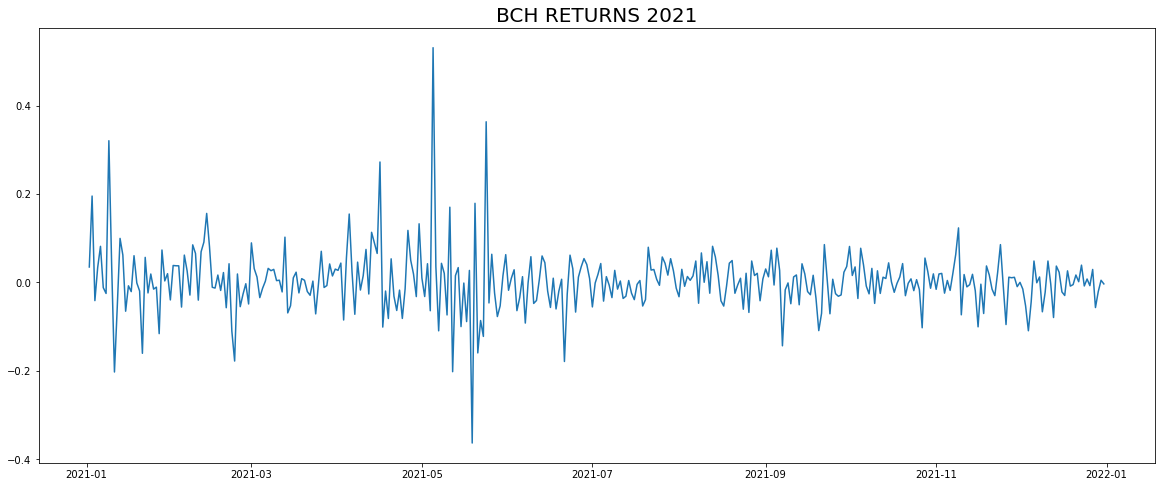

In [14]:
plt.figure(figsize=(20,8))
returns=df['Close'].pct_change().dropna()
plt.plot(returns)
plt.title('BCH RETURNS 2021',fontsize=20)
plt.show

In [15]:
train_mc=returns.iloc[:splitting_landmark]
test_mc=returns.iloc[splitting_landmark:]

In [16]:
# Tính toán các thông số
# T là độ dài giai đoạn mô phỏng
# N là số điểm dữ liệu trong giai đoạn mô phỏng
# s0 là giá trị khởi điểm cho giai đoạn mô phỏng
# n_sim là số lần mô phỏng
# mu là giá trị trung bình trong giai đoạn đánh giá
# sigma là độ lệch chuẩn trong giai đoạn đánh giá
T=len(test_mc)
N=len(test_mc)
s0=df['Close'][train_mc.index[-1]]
n_sim=1000
mu=train_mc.mean()
sigma=train_mc.std()

In [17]:
# Thực hiện tạo hàm mô phỏng theo công thức SDE
def simulate_gbm(s0,mu,sigma,n_sim,T,N,random_seed=1):
    np.random.seed(1)
    # Xác định số điểm dữ liệu mô phỏng
    dt=T/N
    # Xác định tham số ngẫu nhiên Brownian Motion
    dW=np.random.normal(scale=np.sqrt(dt),size=(n_sim,N))
    # Tạo ma trận để lưu giữ kết quả
    W=np.cumsum(dW,axis=1)
    time_step=np.linspace(dt,T,N)
    time_steps=np.broadcast_to(time_step,(n_sim,N))
    # Thiết lập công thức SDE
    s_t=s0*np.exp((mu-0.5*sigma**2)*time_steps+sigma*W)
    # Chèn giá trị khởi điểm vào đầu kết quả mô phỏng
    s_t=np.insert(s_t,0,s0,axis=1)
    return s_t

In [18]:
# Thực hiện mô phỏng theo hàm đã tạo
gbm_sim=simulate_gbm(s0,mu,sigma,n_sim,T,N)

In [19]:
# Xác định các mốc thời gian trên biểu đồ
last_train_date_mc=train_mc.index[-1]
first_test_date_mc=test_mc.index[0]
last_test_date_mc=test_mc.index[-1]
indices=df['Close'][last_train_date_mc:last_test_date_mc].index
index=[date.date() for date in indices]
gbm_sim_df=pd.DataFrame(np.transpose(gbm_sim),index=index)

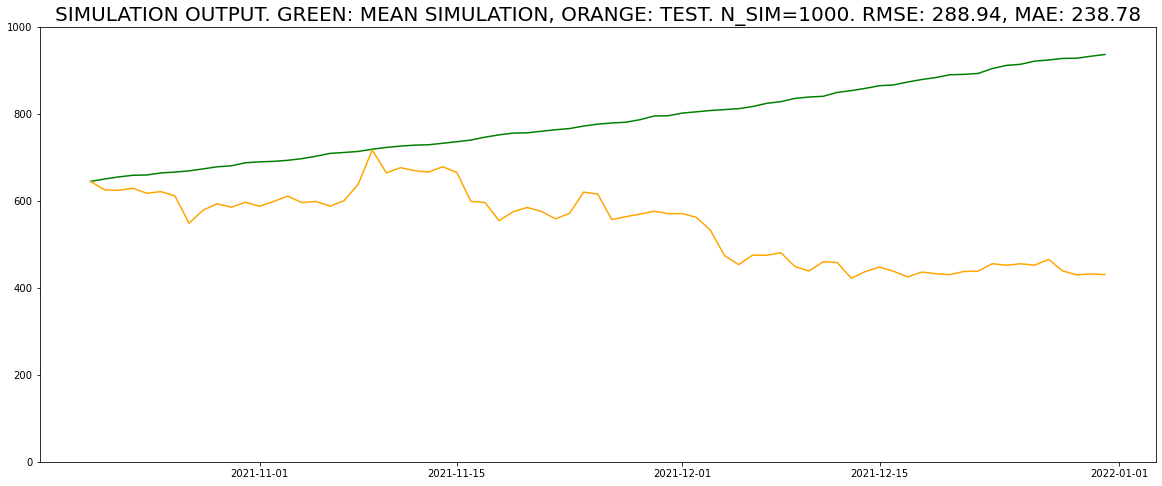

In [20]:
ax=gbm_sim_df.plot(alpha=0.2,legend=False,figsize=(20,8),color='white')
line_1=ax.plot(index,gbm_sim_df.mean(axis=1),color='green')
line_2=ax.plot(index,df['Close'][last_train_date_mc:last_test_date_mc],color='orange')
rmse = np.sqrt(mean_squared_error(df['Close'][last_train_date_mc:last_test_date_mc], gbm_sim_df.mean(axis=1)))
mae=mean_absolute_error(df['Close'][last_train_date_mc:last_test_date_mc], gbm_sim_df.mean(axis=1))
ax.set_title(f'Simulation Output. Green: Mean Simulation, Orange: Test. N_SIM={n_sim}. RMSE: {rmse:.2f}, MAE: {mae:.2f}'.upper()
             ,fontsize=20)
ax.set_ylim(0,1000)
plt.show()


# Mô Hình ARIMA

In [21]:
# Chia tập train - test
train_arima=df.iloc[:splitting_landmark]['Close']
test_arima=df.iloc[splitting_landmark:]['Close']
print(f'Train: {len(train_arima)}, Test: {len(test_arima)}')

Train: 292, Test: 73


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


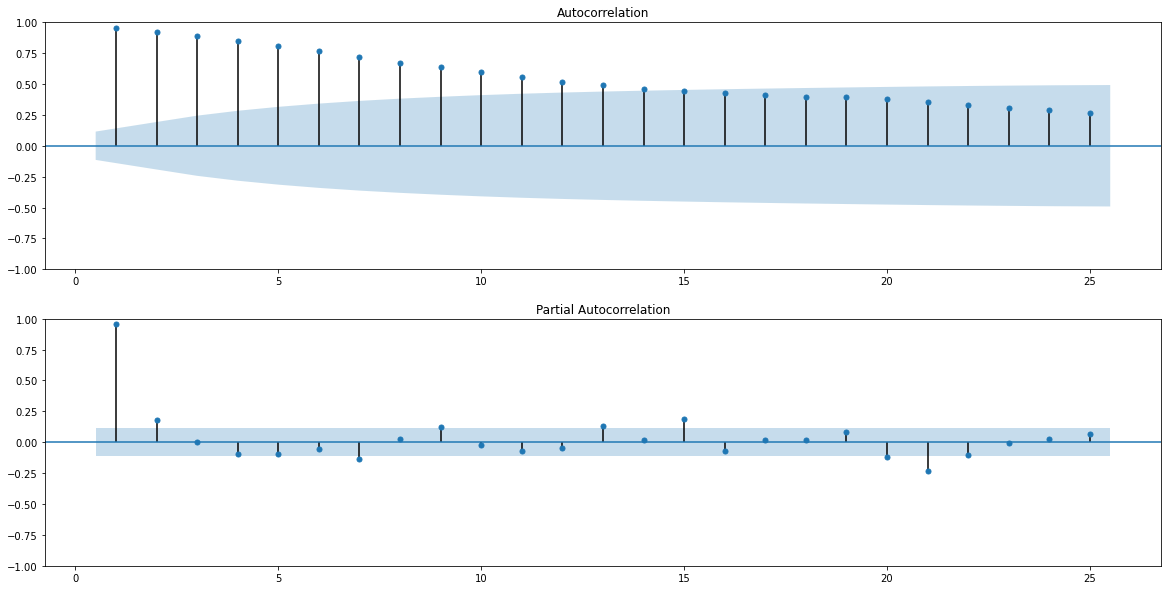

In [22]:
#Vẽ biểu đồ ACF và PACF
def plot_acf_pacf(df):
    fig, ax = plt.subplots(2, figsize=(20,10))
    plot_acf(df, zero=False, ax=ax[0])
    plot_pacf(df, zero=False, ax=ax[1])
    return plt.show()

plot_acf_pacf(train_arima)

In [23]:
#Kiểm tra tính dừng của dữ liệu train
result = adfuller(train_arima)
print('ADF test for train dataset')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF test for train dataset
ADF Statistic: -1.965549
p-value: 0.301880
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


In [24]:
# Kiểm tra tính dừng của sai phân bậc 1 của train
train_diff_1 = train_arima.diff()
train_diff_1.dropna(axis=0, inplace=True)
result = adfuller(train_diff_1)
print('ADF test for train_diff_1 dataset')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF test for train_diff_1 dataset
ADF Statistic: -6.087983
p-value: 0.000000
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


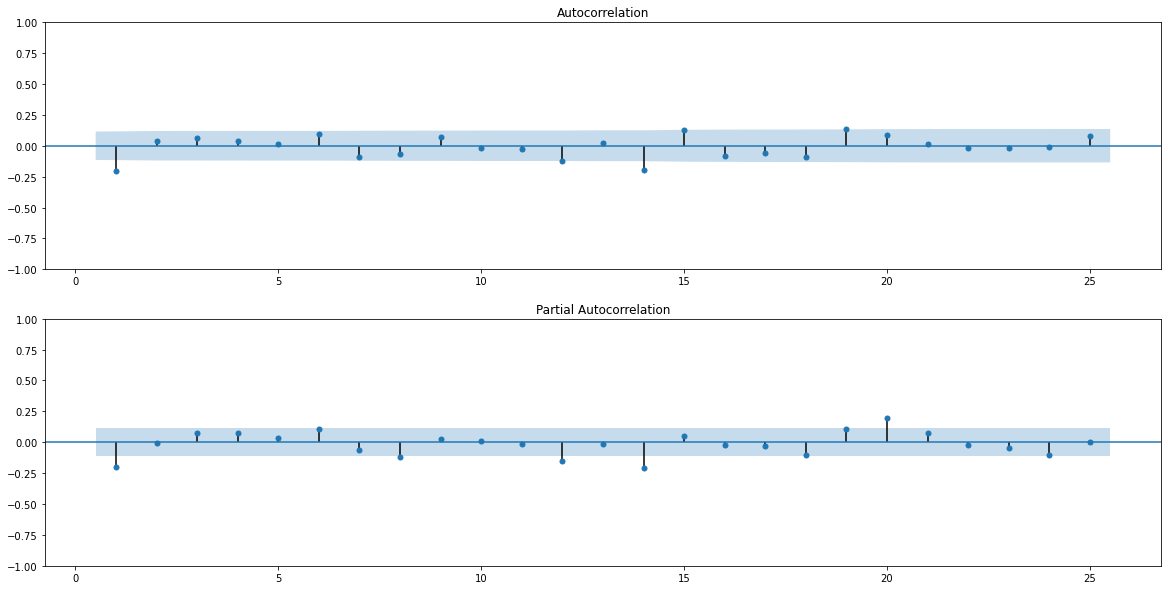

In [25]:
# Vẽ biểu đồ ACF và PACF của sai phân
plot_acf_pacf(train_diff_1)

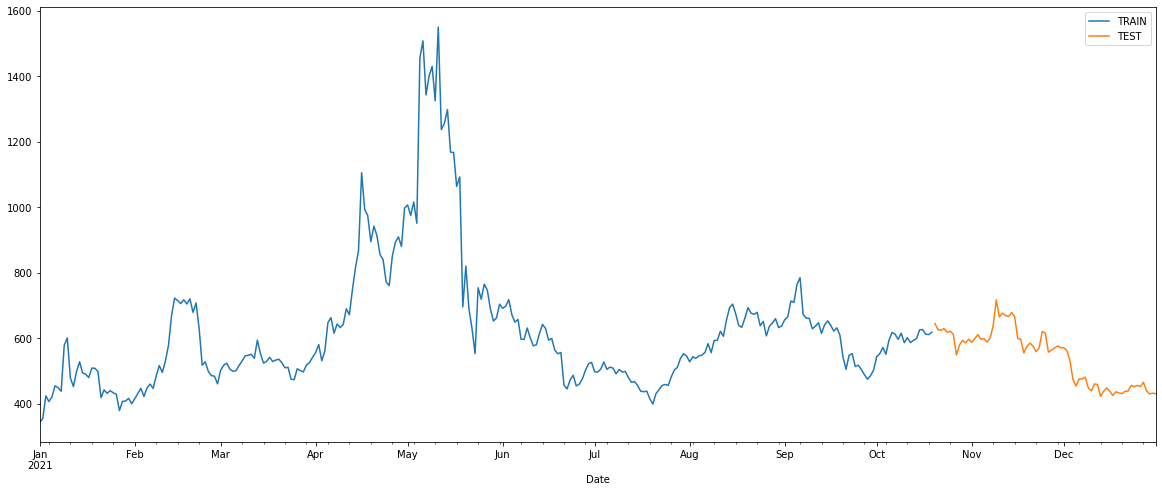

In [26]:
# Vẽ tập train và test
fig, ax = plt.subplots(figsize=(20,8))
train_arima.plot(ax=ax, label='TRAIN')
test_arima.plot(ax=ax, label='TEST')
ax.legend()
plt.show()

In [27]:
# Auto Arima
import pmdarima
best_model = pmdarima.auto_arima(train_arima, 
                                trace=1,
                                test='adf',
                                error_action ='ignore',
                                suppress_warnings = True, 
                                seasonal = False, 
                                stepwise = True, 
                                approximation = False, 
                                n_jobs = -1, 
                                seasonal_test = None)

C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3215.269, Time=3.78 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3224.019, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3214.095, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3214.844, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3222.089, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3216.094, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3216.095, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3216.776, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3212.198, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3214.196, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3214.197, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3212.949, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3214.860, Time=0.37 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.680 seconds


In [28]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1604.099
Date:                Tue, 26 Apr 2022   AIC                           3212.198
Time:                        22:27:11   BIC                           3219.544
Sample:                             0   HQIC                          3215.141
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1998      0.033     -6.013      0.000      -0.265      -0.135
sigma2      3592.8423     90.218     39.824      0.000    3416.018    3769.667
Ljung-Box (L1) (Q):                   0.00   Jarque-

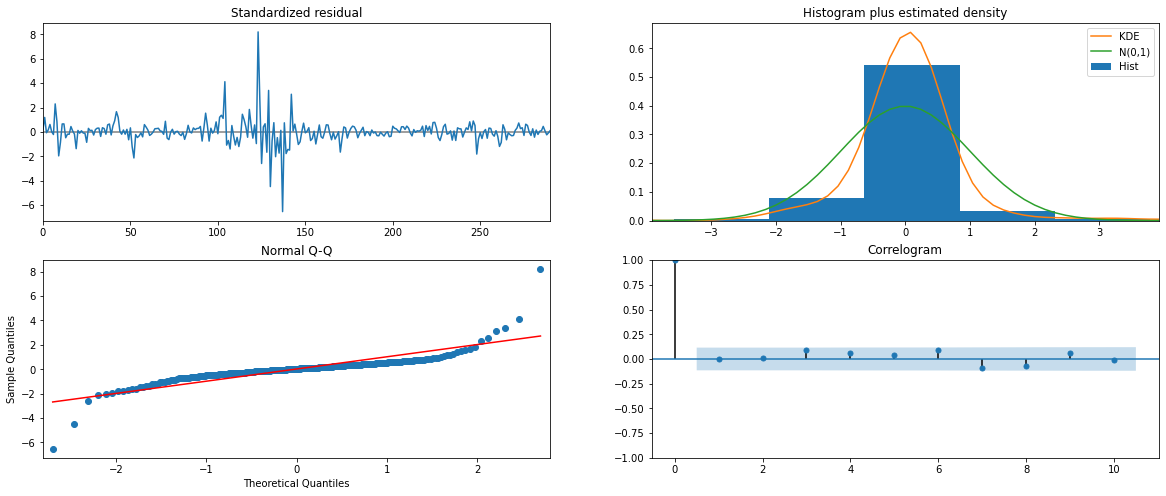

In [29]:
# Đồ thị phân phối phần dư của mô hình
plot_diag = best_model.plot_diagnostics(figsize=(20,8))

In [30]:
# Kiểm định tự tương quan của phần dư
sm.stats.acorr_ljungbox(best_model.resid(),  return_df=True)

,lb_stat,lb_pvalue
1,0.001180,0.972601
2,0.316056,0.853826
3,2.103959,0.551112
4,3.072422,0.545780
5,3.849419,0.571293
6,5.873518,0.437507
7,8.157551,0.318907
8,8.361102,0.399015
9,9.950243,0.354528
10,10.437000,0.403025


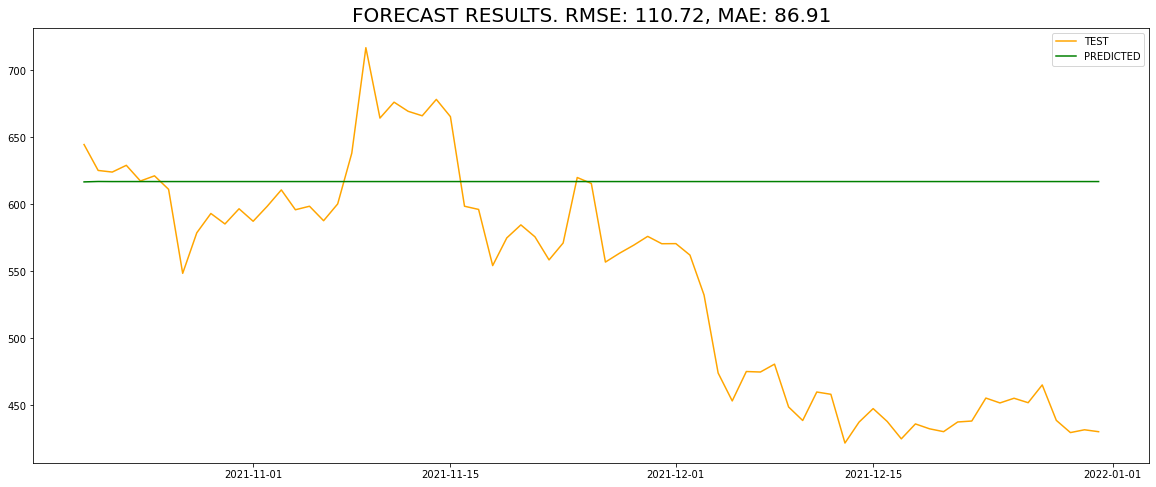

In [31]:
# Vẽ biểu đồ test và prediction
predicted = best_model.predict(n_periods=len(test_arima))
predicted = pd.DataFrame(predicted, index=test_arima.index, columns=['predicted'])
plt.figure(figsize=(20,8))
plt.plot(test_arima, label='TEST',color='orange')
plt.plot(predicted, label='PREDICTED',color='green')
rmse = np.sqrt(mean_squared_error(test_arima, predicted))
mae=mean_absolute_error(test_arima,predicted)
plt.title(f'FORECAST RESULTS. RMSE: {rmse:.2f}, MAE: {mae:.2f}',fontsize=20)
plt.legend()
plt.show()

In [32]:
# Chia nhỏ giai đoạn dự đoán thành 7 ngày
def seven_steps_forecast(DF):
    test_size=len(test_arima)
    prediction_7=[]
    while test_size>0:
        train=DF['Close'].iloc[:-test_size]
        test=DF['Close'].iloc[-test_size:]
        if test_size>=7:
            model=pmdarima.auto_arima(train, 
                                trace=1,
                                test='adf',
                                error_action ='ignore',
                                suppress_warnings = True, 
                                seasonal = False, 
                                stepwise = True, 
                                approximation = False, 
                                n_jobs = -1, 
                                seasonal_test = None)
            predicted=model.predict(n_periods=7).tolist()
            for i in predicted:
                prediction_7.append(i)
            test_size-=7
        else:
            model=pmdarima.auto_arima(train, 
                                trace=1,
                                test='adf',
                                error_action ='ignore',
                                suppress_warnings = True, 
                                seasonal = False, 
                                stepwise = True, 
                                approximation = False, 
                                n_jobs = -1, 
                                seasonal_test = None)
            predicted=model.predict(n_periods=test_size).tolist()
            for i in predicted:
                prediction_7.append(i)
            test_size=0
    return prediction_7

In [33]:
predict_7=seven_steps_forecast(df)

C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3215.269, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3224.019, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3214.095, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3214.844, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3222.089, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3216.094, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3216.095, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3216.776, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3212.198, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3214.196, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3214.197, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3212.949, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3214.860, Time=0.31 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.658 seconds
Performing stepwise se

C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3285.577, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3294.768, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3284.536, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3285.299, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3292.834, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3286.535, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3286.535, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3287.194, Time=0.85 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3282.636, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3284.634, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3284.635, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3283.401, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3285.274, Time=0.37 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.228 seconds
Performing stepwise search to minimize aic


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3356.917, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3366.515, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3355.985, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3356.739, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3364.575, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3357.980, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3357.982, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3358.658, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3354.072, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3356.068, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3356.070, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3354.828, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3356.730, Time=0.36 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.284 seconds
Performing stepwise search to minimize aic


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3429.546, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3438.890, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3428.550, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3429.291, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3437.017, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3430.548, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3430.548, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3431.200, Time=0.81 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3426.725, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3428.723, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3428.724, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3427.468, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3429.353, Time=0.34 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.313 seconds
Performing stepwise search to minimize aic


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3501.139, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3511.176, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3500.281, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3501.016, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3509.235, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3502.272, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3502.277, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3503.007, Time=1.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3498.376, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3500.368, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3500.371, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3499.114, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3501.081, Time=0.46 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.526 seconds
Performing stepwise search to minimize aic


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3571.594, Time=1.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3581.899, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3570.788, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3571.574, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3579.946, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3572.785, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3572.787, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3573.439, Time=0.75 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3568.855, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3570.853, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3570.854, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3569.643, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3571.495, Time=0.39 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.100 seconds
Performing stepwise search to minimize aic


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3642.853, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3653.439, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3642.230, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3642.927, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3651.486, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3644.216, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3644.222, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3645.001, Time=0.77 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3640.299, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3642.286, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3642.291, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3640.997, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3644.299, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.636 seconds
Performing stepwise search to minimize aic


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3714.448, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3724.706, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3713.697, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3714.385, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3722.722, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3715.688, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3715.692, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3716.431, Time=0.91 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3711.719, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3713.710, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3713.714, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3712.407, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3714.450, Time=0.56 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.304 seconds
Performing stepwise search to minimize aic


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3784.502, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3795.223, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3783.946, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3784.618, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3793.231, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3785.931, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3785.938, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3786.660, Time=0.97 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3781.958, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3783.942, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3783.948, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3782.629, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3785.957, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.079 seconds
Performing stepwise search to minimize aic


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3853.689, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3864.807, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3853.276, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3853.945, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3862.815, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3855.257, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3855.265, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3857.282, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3851.288, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3853.268, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3853.276, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3851.955, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3855.287, Time=0.11 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.118 seconds
Performing stepwise search to minimize aic


C:\Users\Khang Lam\AppData\Roaming\Python\Python38\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3922.945, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3934.467, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3922.630, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3923.319, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3932.475, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3924.610, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3924.618, Time=0.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3926.635, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3920.642, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3922.623, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3922.631, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3921.331, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3924.641, Time=0.18 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.548 seconds


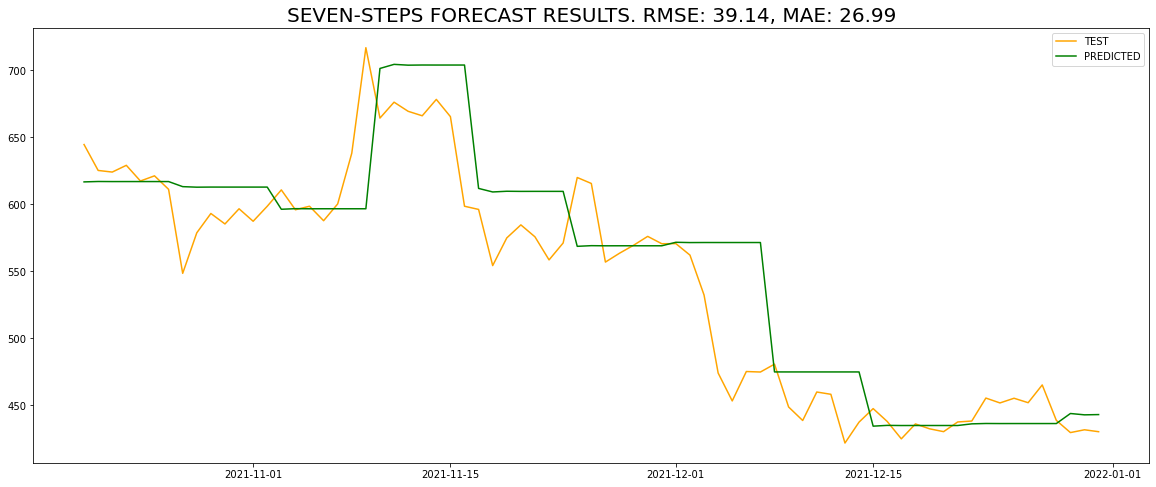

In [34]:
# Vẽ biểu đồ test và prediction
prediction_7=pd.Series(predict_7,index=test_arima.index)
plt.figure(figsize=(20,8))
plt.plot(test_arima, label='TEST',color='orange')
plt.plot(prediction_7, label='PREDICTED',color='green')
rmse = np.sqrt(mean_squared_error(test_arima, prediction_7))
mae=mean_absolute_error(test_arima,prediction_7)
plt.title(f'SEVEN-STEPS FORECAST RESULTS. RMSE: {rmse:.2f}, MAE: {mae:.2f}',fontsize=20)
plt.legend()
plt.show()


In [35]:
# Chia nhỏ giai đoạn dự đoán thành 1 ngày
def one_step_forecast():
    predicted = best_model.predict(n_periods=1)
    return predicted.tolist()[0]
one_step_prediction = []
for x in test_arima:
    predicted = one_step_forecast()
    one_step_prediction.append(predicted)
    # Updates the existing model
    best_model.update(x)

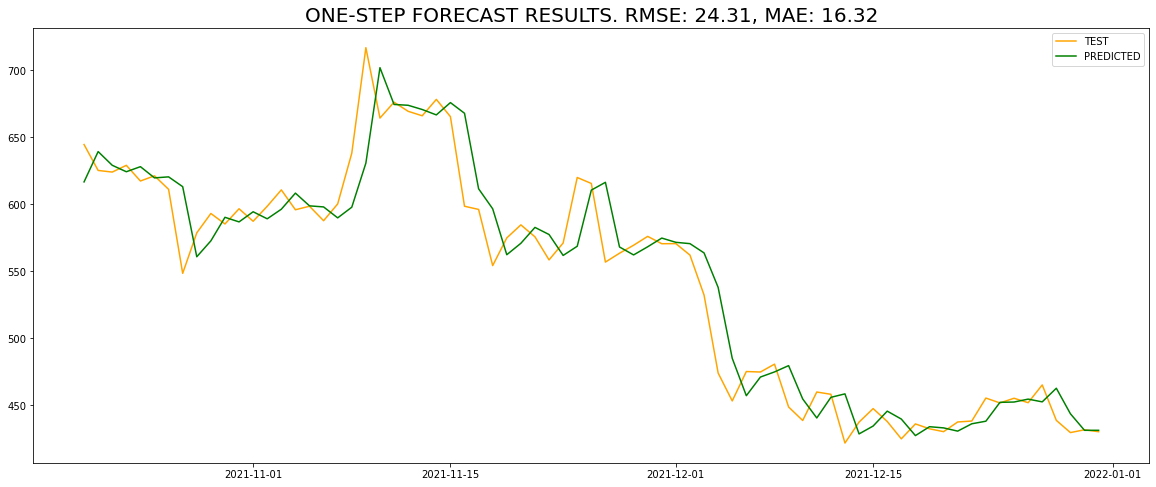

In [36]:
# Vẽ biểu đồ test và prediction
predicted = pd.DataFrame(one_step_prediction, index=test_arima.index, columns=['predicted'])
plt.figure(figsize=(20,8))
plt.plot(test_arima, label='TEST',color='orange')
plt.plot(predicted, label='PREDICTED',color='green')
rmse = np.sqrt(mean_squared_error(test_arima, one_step_prediction))
mae=mean_absolute_error(test_arima,one_step_prediction)
plt.title(f'ONE-STEP FORECAST RESULTS. RMSE: {rmse:.2f}, MAE: {mae:.2f}',fontsize=20)
plt.legend()
plt.show()
# calculate RMSE
